In [1]:
from ultralytics import YOLO

# 1. Load the model (YOLOv12-X-seg for maximum accuracy)
model = YOLO('models/yolo/yolo11s-seg.pt')

# 2. Start Training
results = model.train(
    data='configs/driveindia_yolo11.yaml',
    epochs=50,
    imgsz=1024,          # High res for small object detection
    batch=8,            # Adjust based on GPU VRAM (e.g., 24GB+)
    augment=True,        # Enable Mosaic, MixUp, and Copy-Paste
    overlap_mask=True,   # Critical for dense traffic where objects overlap
    project='DriveIndia_Seg',
    name='v11s_vru_focus'
)

Ultralytics 8.3.235  Python-3.10.19 torch-2.9.1+cu128 CUDA:0 (NVIDIA RTX A3000 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=configs/driveindia_yolo11.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=models/yolo/yolo11s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=v11s_vru_focus5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patie

In [12]:
model

YOLO(
  (model): SegmentationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_run

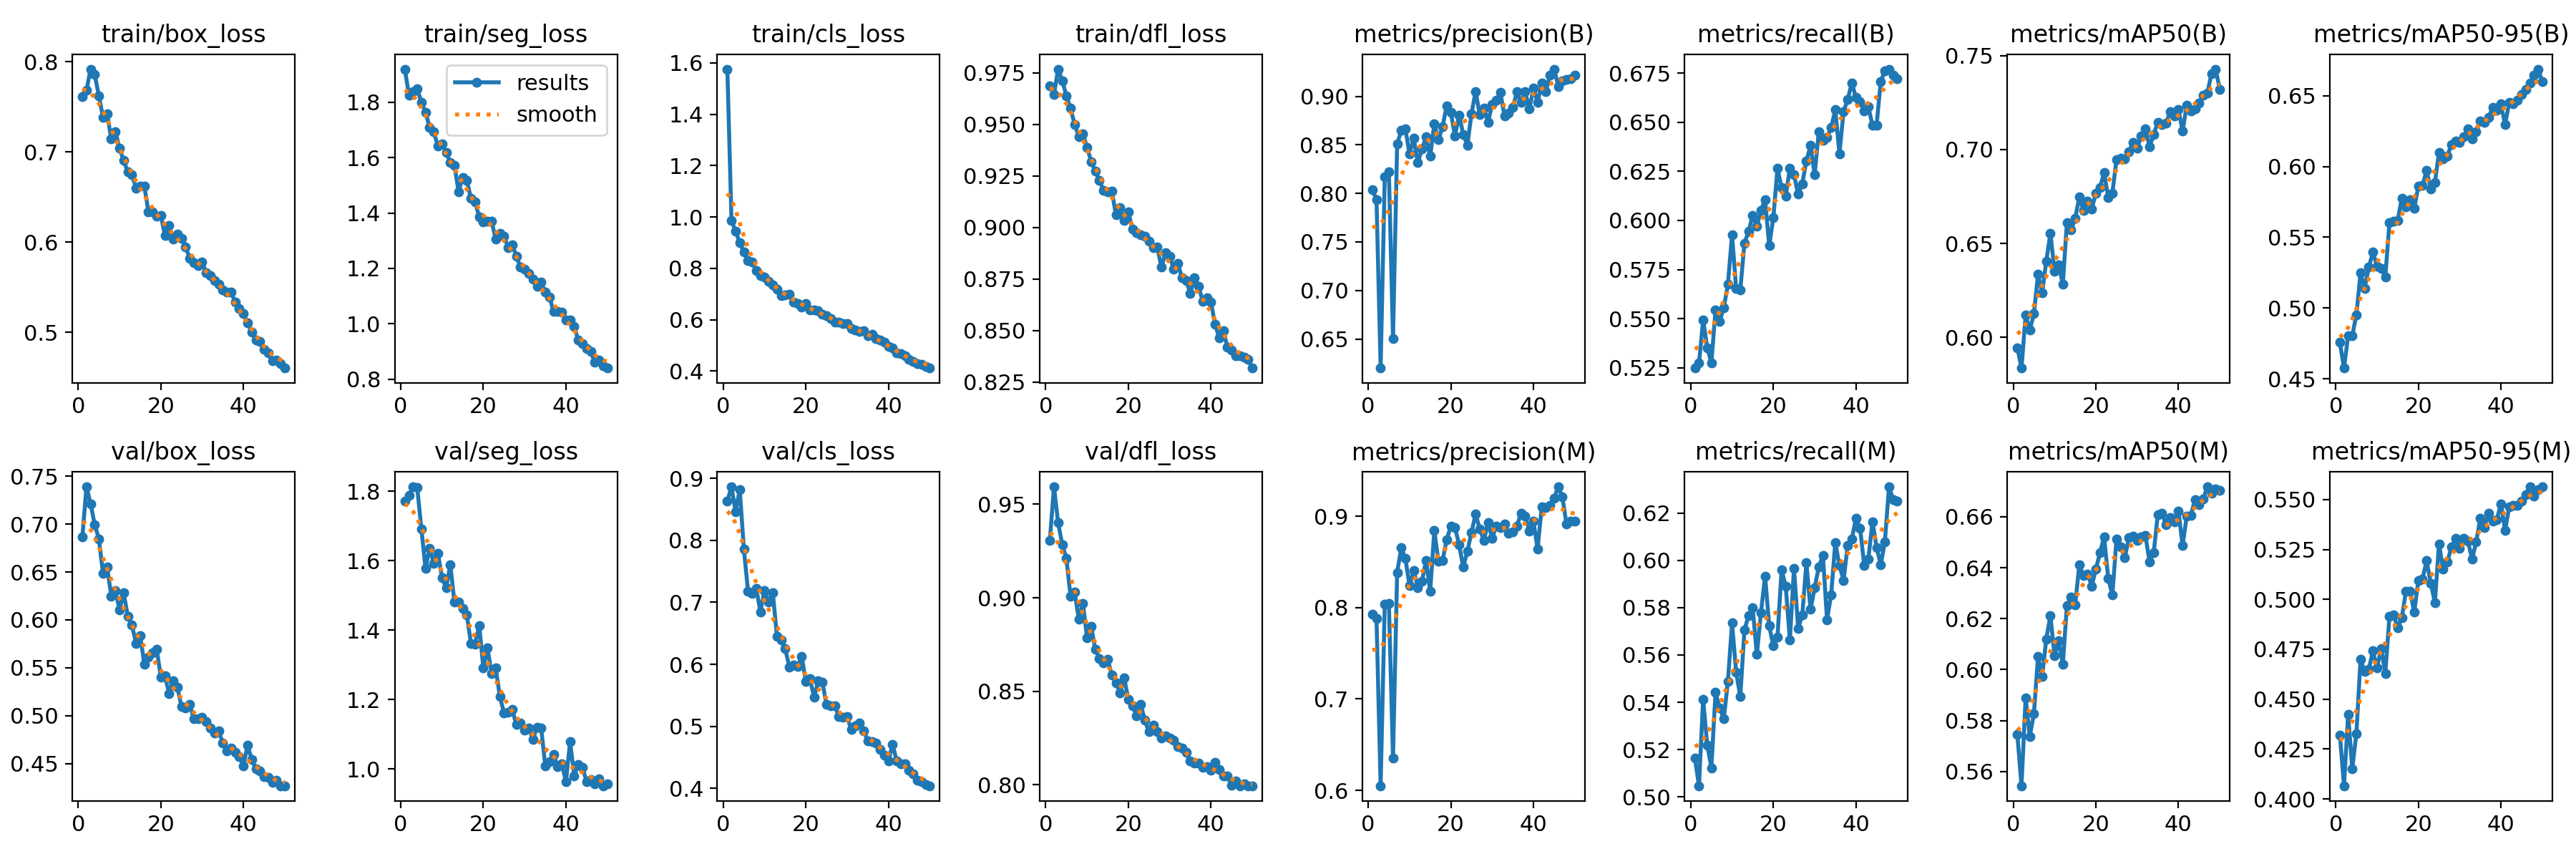

In [7]:
from IPython.display import Image, display

# Display the automatically generated results plot
display(Image(filename='DriveIndia_Seg/v11s_vru_focus5/results.png'))

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training results
results_path = 'DriveIndia_Seg/v11s_vru_focus5/results.csv'
df = pd.read_csv(results_path)

# Clean column names (strip whitespace)
df.columns = [c.strip() for c in df.columns]

# Plotting
plt.figure(figsize=(12, 6))

# Plot Training & Validation Box Loss
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.title('Bounding Box Loss')
plt.legend()

# Plot Training & Validation Segmentation Loss
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train/seg_loss'], label='Train Seg Loss')
plt.plot(df['epoch'], df['val/seg_loss'], label='Val Seg Loss')
plt.title('Segmentation (Mask) Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Load your custom-trained DriveIndia model
bestmodel = YOLO('DriveIndia_Seg/v11s_vru_focus5/weights/best.pt')

# Export to TensorRT (Engine format)
# imgsz: Match your training resolution (e.g., 1024)
# half: Enables FP16 (Half Precision)
# workspace: Allocates GPU memory for the optimization process (in GB)
bestmodel.export(format='engine', imgsz=1024, half=True, workspace=4, simplify=True)

In [ ]:
# INT8 Export with Calibration
# 'data' points to your DriveIndia yaml so SAM-labeled images are used for calibration
model.export(format='engine', int8=True, data='configs/driveindia_yolo11.yaml', imgsz=1024)

In [ ]:
import cv2
from ultralytics import YOLO

# Load the optimized TensorRT engine
engine_model = YOLO('runs/segment/v12_vru_focus/weights/best.engine')

# Run inference on a video stream from the vehicle's camera
# stream=True uses a generator to prevent memory overflow
results = engine_model.predict(source='camera_feed.mp4', imgsz=1024, stream=True, conf=0.4)

for r in results:
    # Access the high-speed segmentation masks
    masks = r.masks 
    annotated_frame = r.plot()
    
    cv2.imshow("DriveIndia Real-Time Perception", annotated_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break